# 2.1 Library Setup & Data Loading

In [1]:
# Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Libraries for Automated "First Pass" Scan
from ydata_profiling import ProfileReport

In [2]:
# Libraries for Redundancy Analysis
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster

In [ ]:
# Libraries for Feature Selection
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Libraries for SHAP
import shap

In [ ]:
# Libraries for Segmentation via UMAP
import umap
from sklearn.preprocessing import StandardScaler

In [3]:
# Load The Training Dataset
train_df = pd.read_parquet('../data/processed/train_df.parquet', engine='fastparquet')
print(f"Training DataFrame Shape: {train_df.shape}")

Training DataFrame Shape: (52004, 140)


# 2.2 Automated "First Pass" & Data Health

This paper discusses the necessity of automated tools to handle the "scale and complexity of modern data," which traditional manual EDA cannot.
* Arora, A., Varghese, D. M., & Kaur, P. (2025). AutoEDA: An Automated Exploratory Data Analysis Framework for Data-Driven Insights. Journal of Big Data. This paper discusses the necessity of automated tools to handle the "scale and complexity of modern data," which traditional manual EDA cannot.

In [3]:
# Automated Profiling Report
# Identify missing values, zeros, and high correlations instantly
profile = ProfileReport(train_df, title="Telco Churn Data Health Check", minimal=True)
profile.to_file('../reports/data_health_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 140/140 [00:10<00:00, 13.50it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
# Check for Zero Variance
zero_var_cols = [col for col in train_df.columns if train_df[col].nunique() <= 1]

if len(zero_var_cols) == 0:
    print("Confirmed: No columns with zero variance. Every feature has data.")
else:
    print(f"Found {len(zero_var_cols)} columns with zero variance: {zero_var_cols}")

Confirmed: No columns with zero variance. Every feature has data.


### Data Profiling & Health Check Summary
**Objective:** assessed data quality, sparsity, and distribution properties.

**Key Findings:**
* **Data Integrity:** The dataset contains no missing values and no zero-variance columns.
* **Cardinality:** `customer_id` acts as a unique key and will be removed. Several continuous features (e.g., `spend_change_2wk`) exhibit 100% cardinality (unique values per user), which is expected for high-precision calculated metrics.
* **Correlations:** The initial automated scan (in minimal mode) suppressed correlation computations. **Action Taken:** A manual Spearman correlation analysis will be performed (see next section), confirming strong monotonic relationships between base app usage and aggregate data features.
* **Target Variable:** The churn rate is **23.1%**, requiring recall-oriented evaluation metrics or threshold-independent metrics (AUC-ROC) rather than accuracy.
* **Sparsity:** High-sparsity features contain ~40% zeros, supporting the use of **Weight of Evidence (WoE)** binning.
* **Distribution:** Significant skewness was observed in `distinct_services_w1_2` ($\gamma_1 \approx -131$), indicating a highly concentrated user behavior pattern that will require non-linear transformation or binning (depending on which algorithm selected).

**Action Taken:**
* Dropped identifier column (`customer_id`).
* Proceeding to **Hierarchical Clustering** to visualize feature redundancy.

# 2.3 Redundancy Analysis

These papers emphasize redundancy analysis with hierarchical flustering of features (dendrograms) to handle the curse of dimensionality
* Jambekar, P., & Nandi, S. (2022). Mitigating the multicollinearity problem and its machine learning approach: A review. Mathematics, 10(8), 1283. https://doi.org/10.3390/math10081283
* Chavent, M., Kuentz-Simonet, V., Labenne, A., & Saracco, J. (2022). Hierarchical clustering: Visualization, feature importance and model selection. Computational Statistics, 37, 1–25. https://doi.org/10.1007/s00180-022-01217-w

In [4]:
# Drop ONLY customer_id
train_df.drop(columns=['customer_id'], inplace=True)

Manual Check: Correlation between Total Data and YouTube is: 0.5844


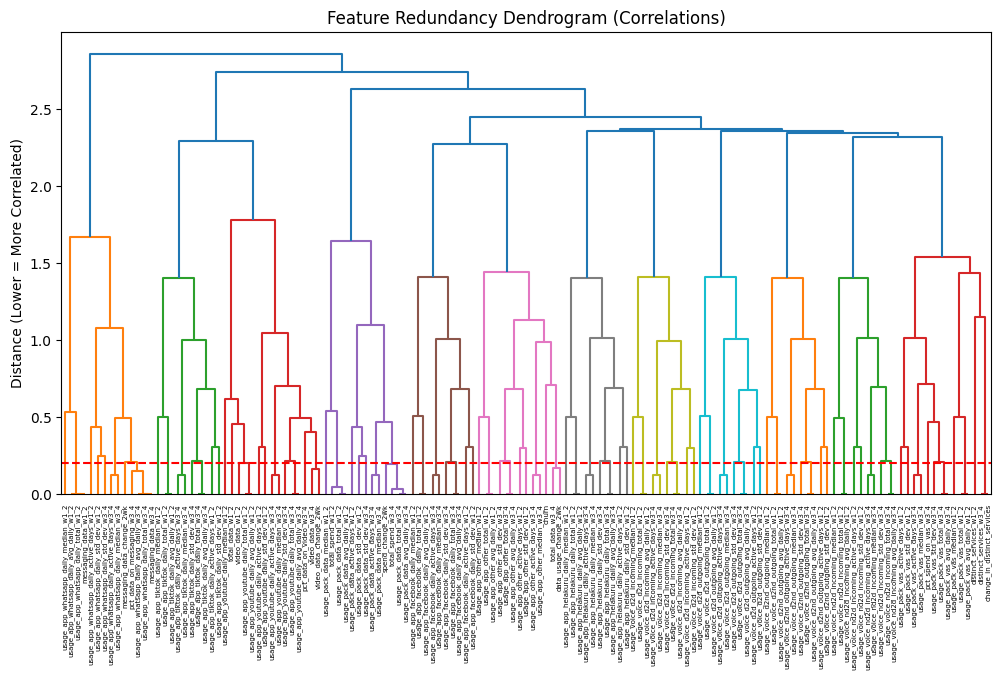

In [8]:
# Calculate Spearman Correlation
# This captures non-linear relationships better than the Profiling Report
corr_matrix = train_df.corr(method='spearman')

# Quick Logic Check:
# Verify the specific relationship between two columns with potential high correlation
check_val = corr_matrix.loc['total_data_w1_2', 'usage_app_youtube_daily_total_w1_2']
print(f"Manual Check: Correlation between Total Data and YouTube is: {check_val:.4f}")

# Visualization: Hierarchical Clustering (Dendrogram)
plt.figure(figsize=(12, 6))
# Convert correlation to distance
# If two features are not correlated at all (0), they are totally different.
# The distance should be 1 (or maximum)
dist_matrix = 1 - np.abs(corr_matrix)
clustering = linkage(squareform(dist_matrix), method='ward')

dendrogram(clustering, labels=train_df.columns, leaf_rotation=90)
plt.title("Feature Redundancy Dendrogram (Correlations)")
plt.ylabel("Distance (Lower = More Correlated)")
plt.axhline(y=0.2, color='r', linestyle='--', label='High Redundancy Threshold')

# Save the figure
plt.savefig('../reports/figures/redundancy_dendrogram.png', bbox_inches='tight')

plt.show()

*Notes:*
* *Total Data and YouTube Data are related, but not identical. There are likely many users who use high data without using YouTube (Maybe TikTok). We keep features with correlation like this since they tell different stories.*
* *The dendrogram is too huge to read. We will use a technique called "Cutting the Tree" and tell Python: "If any features are connected effectively at the ankles (extremely similar, distance < 0.2), group them together and inform me."*

In [7]:
# Cut the dendrogram to find clusters of identical features
# t=0.2 means "Only group features that are >80% similar (Spearman)"
# We can adjust t: 0.1 is very strict (must be almost identical), 0.5 is loose.
clusters = fcluster(clustering, t=0.2, criterion='distance')

# Create a DataFrame to view the groups
cluster_df = pd.DataFrame({'Feature': train_df.columns, 'Cluster': clusters})

# Find clusters that have more than 1 feature (Redundant Groups)
redundant_groups = cluster_df.groupby('Cluster').filter(lambda x: len(x) > 1)

# Print the results
if len(redundant_groups) == 0:
    print("No highly redundant features found (at threshold 0.2).")
    print("This means the engineered features are distinct enough to keep!")
else:
    print(f"Found {redundant_groups['Cluster'].nunique()} groups of redundant features.")
    print("Here are the features that are basically copies of each other:\n")
    
    for cluster_id in redundant_groups['Cluster'].unique():
        features_in_group = redundant_groups[redundant_groups['Cluster'] == cluster_id]['Feature'].tolist()
        print(f"Group {cluster_id}: {features_in_group}")
        # Keep the simplest one, drop the others.

Found 39 groups of redundant features.
Here are the features that are basically copies of each other:

Group 34: ['usage_app_facebook_daily_total_w1_2', 'usage_app_facebook_daily_avg_daily_w1_2']
Group 37: ['usage_app_facebook_daily_total_w3_4', 'usage_app_facebook_daily_avg_daily_w3_4']
Group 36: ['usage_app_facebook_daily_active_days_w3_4', 'usage_app_facebook_daily_median_w3_4']
Group 16: ['usage_app_youtube_daily_total_w1_2', 'usage_app_youtube_daily_avg_daily_w1_2']
Group 23: ['usage_app_youtube_daily_total_w3_4', 'usage_app_youtube_daily_avg_daily_w3_4']
Group 22: ['usage_app_youtube_daily_active_days_w3_4', 'usage_app_youtube_daily_median_w3_4']
Group 9: ['usage_app_tiktok_daily_total_w1_2', 'usage_app_tiktok_daily_avg_daily_w1_2']
Group 12: ['usage_app_tiktok_daily_total_w3_4', 'usage_app_tiktok_daily_avg_daily_w3_4']
Group 11: ['usage_app_tiktok_daily_active_days_w3_4', 'usage_app_tiktok_daily_median_w3_4']
Group 1: ['usage_app_whatsapp_daily_total_w1_2', 'usage_app_whatsapp_d

### Redundancy Analysis (Hierarchical Clustering) Summary
**Objective:** Identify collinear features to prevent model instability and simplify dimensionality.

**Method:** Performed Hierarchical Clustering (Ward's Linkage) using a Spearman correlation matrix to detect non-linear dependencies.

**Key Findings:**
* **High Multicollinearity:** Identified **39 groups** of highly redundant features (Spearman correlation > 0.8 / Distance < 0.2).
* **Source of Redundancy:** The majority of overlaps stem from mathematical coupling between engineered aggregates. For example, `Total Usage` and `Average Daily Usage` are mathematically distinct but provide identical variance signals for apps like Facebook and YouTube.
* **Feature Clusters:** Distinct clusters were observed grouping "Volume" metrics (Total/Avg) separately from "Engagement" metrics (Active Days) in some cases, but heavily overlapping in others.

**Action Taken:**
* **Strategy:** Adopted a **"Flag and Validate"** approach.
* **Decision:** Instead of immediate removal, all redundant variants are **retained** for the next phase (Feature Importance). This allows for an empirical comparison to determine whether "Volume" (Total MB) or "Frequency" (Active Days) is the superior predictor of churn before final pruning.